In [1]:
import numpy as np
import pandas as pd

The data is retrieved from Jordà et al. (2017). Short-term nominal interest rate, long-term nominal interest rate and consumer price indices. The inflation rate is constructed as log-differences of consumer price indices. The base year of all the consumer prices is 1990, expressed as 100. All the rates are expressed as percentage point. Each set of three variables is retrieved for 8 OECD countries : Canada, France, Germany, Italy, Japan, Switzerland, the United Kingdom and the United States, from 1870 to 2016.
As such, the model estimated with this collected data on m = 8 countries results in τ = 27 trends and n = 24 cyclical components over T = 147 periods of time.

In [3]:
data = pd.read_excel("data_inf_var_clean_switz.xlsx")
year = data[['year']]
data.drop(['year'],axis=1,inplace=True)
data.head()
obs=3 # Number of observables per country
T=data.shape[0] # Number of years
n=data.shape[1] # Number of observables
nb = n//obs # Number of countries
r = 6*nb + obs # Total number of latent variables, the global components (=obs) + the cyclical and long term components of each observables for all countries (=nb*3*2)

vector_0=np.zeros((nb, 1), dtype=int)
vector_1=np.ones((nb, 1), dtype=int)
matrix_0=np.zeros((nb, nb), dtype=int)
I = np.identity(nb)

R_1_2 = 0*np.identity(n) # standard deviation of white noise vector W
R=np.dot(R_1_2,np.transpose(R_1_2))
X = np.ones((T,1),dtype=int) # Vector of exogenous variables
A = np.zeros((1,n), dtype=int) # Coefficient matrix of exogenous variables

In [4]:
init_cond_values = np.matrix([[2,0,2.5,0,0,0,0,0,0],[ # Expected values
                         1,1,2,0.5,0.5,1,0.5,0.5,1]]) # Standard deviations

xi_10 = np.empty((r,1)) # Empty vector of initial values
for i in range(len(xi_10)): # Fill the vector using assumptions
    if i == 0:
        xi_10[0] = init_cond_values[0,0]
    elif i == nb+1:
        xi_10[nb+1] = init_cond_values[0,1]
    elif i == 2*(nb+1):
        xi_10[nb+1+nb+1] = init_cond_values[0,2]
    else:
        xi_10[i] = 0

In [6]:
P_10 = init_cond_values[1,obs]**2*np.identity(r)
P_10[0,0]=init_cond_values[1,0]**2
P_10[(nb+1),(nb+1)]=init_cond_values[1,1]**2
P_10[(nb+1+nb+1),(nb+1+nb+1)]=init_cond_values[1,2]**2
for i in range((1+nb+1+nb+2),(1+nb+1+nb+1+nb+1)):
    P_10[i-1,i-1]=init_cond_values[1,(2*obs)-1]**2
for i in range((1+nb+1+nb+1+nb+1),(1+nb+1+nb+1+nb+nb+1)):
    P_10[i-1,i-1]=init_cond_values[1,(2*obs)]**2
for i in range((1+nb+1+nb+1+nb+nb+1),(1+nb+1+nb+1+nb+nb+nb+1)):
    P_10[i-1,i-1]=init_cond_values[1,(2*obs)+1]**2
for i in range((1+nb+1+nb+1+nb+nb+nb+1),(1+nb+1+nb+1+nb+nb+nb+nb+1)):
    P_10[i-1,i-1]=init_cond_values[1,(2*obs)+2]**2

In [11]:
##### Restrictions
max_lambda, max_sigma_rw, max_sigma_r,max_sigma_tsw, max_sigma_ts, max_sigma_piw, max_sigma_pi, max_phi = [1.6, np.sqrt(1/50), np.sqrt(1/25), np.sqrt(1/50), np.sqrt(1/25), np.sqrt(1/10), np.sqrt(1/4), .99]
min_sigma_rw, min_sigma_r, min_sigma_tsw, min_sigma_ts, min_sigma_piw, min_sigma_pi= [.09, .09, .09, .09, 0, 0]

sigmarw = -np.log((max_sigma_rw-min_sigma_rw)/(0.1-min_sigma_rw)-1)
sigmar = -np.log((max_sigma_r-min_sigma_r)/(0.1-min_sigma_r)-1)
sigmatsw = -np.log((max_sigma_tsw-min_sigma_tsw)/(0.1-min_sigma_tsw)-1)
sigmats = -np.log((max_sigma_ts-min_sigma_ts)/(0.1-min_sigma_ts)-1)
sigmapiw = -np.log((max_sigma_piw-min_sigma_piw)/(np.sqrt(1/50)-min_sigma_piw)-1)
sigmapi = -np.log((max_sigma_pi-min_sigma_pi)/(np.sqrt(1/50)-min_sigma_pi)-1)

In [12]:
##### Priors
param_0 = np.concatenate((np.full((1,nb-1),-np.log(max_lambda-1)),
              np.full((1,2*obs+obs),-2),
              np.array([sigmarw,sigmar,sigmatsw,sigmats,sigmapiw,sigmapi,2,2,4])),axis=None)

In [13]:
#### Kalman Filter creation
def Kalman_filter(df,X,F,Q,A,H,R,xi_10,P_10):
    Y=df.to_numpy()
    T=Y.shape[0]
    n=Y.shape[1]
    r=xi_10.shape[0]

    matrix_xi_tt = np.empty((T,r))
    matrix_xi_tp1t = np.empty((T,r))
    matrix_P_tt = np.empty((T,r**2))
    matrix_P_tp1t = np.empty((T,r**2))

    log = 0

    for t in range(0,T):
        indic_available_prev = [data.columns.get_loc(c)
                                 for c in data.columns[data.iloc[[t,]].isna().all()==False]
                                 if c in data]

        Y_na = Y[t,indic_available_prev]
        H_na = H[:,indic_available_prev]
        R_na = R[indic_available_prev,:][:,indic_available_prev]
        A_na = A[:,indic_available_prev]

        if t==0 :
            P_ttm1 = P_10
            xi_ttm1 = xi_10

        else :
            P_ttm1 = np.reshape(matrix_P_tp1t[t-1,:],(r,r))
            xi_ttm1 = np.reshape(matrix_xi_tp1t[[t-1],:],(r,1))
        gain_t = np.linalg.multi_dot([P_ttm1,H,np.linalg.inv(np.linalg.multi_dot([np.transpose(H),P_ttm1,H]) + R)])
        mu_t = np.dot(np.transpose(A),X[[t],:]) + np.dot(np.transpose(H),xi_ttm1)
        sigma_t = (np.linalg.multi_dot([np.transpose(H),P_ttm1,H]) + R)[indic_available_prev,:][:,indic_available_prev]
        
        prev_err = (np.transpose(Y[[t],:]) - mu_t)[indic_available_prev,:]
        xi_tt = xi_ttm1 + np.dot(gain_t[:,indic_available_prev],prev_err)
        P_tt = P_ttm1 - np.linalg.multi_dot([gain_t,np.transpose(H),P_ttm1])

        xi_tp1t = np.dot(F,xi_tt) 
        P_tp1t = np.linalg.multi_dot([F,P_tt,np.transpose(F)]) + Q

        matrix_xi_tt[t,:] = np.reshape(xi_tt,(1,r))
        matrix_xi_tp1t[t,:] = np.reshape(xi_tp1t,(1,r))
        matrix_P_tt[t,:] = np.reshape(P_tt,(1,r**2))
        matrix_P_tp1t[t,:] = np.reshape(P_tp1t,(1,r**2))
        log = log -len(prev_err)/2*np.log(2*np.pi) - .5*np.log(np.linalg.det(sigma_t)) - .5*np.linalg.multi_dot([np.transpose(prev_err),np.linalg.inv(sigma_t),prev_err])

    return [matrix_xi_tt,matrix_P_tt,matrix_xi_tp1t,matrix_P_tp1t,log]


def Kalman_smoother(Y,X,F,Q,A,H,R,xi_10,P_10):
  
    results_KF = Kalman_filter(Y,X,F,Q,A,H,R,xi_10,P_10)
  
    T=Y.shape[0]
    n=Y.shape[1]
    r=xi_10.shape[0]

    matrix_xi_tt = results_KF[0]
    matrix_P_tt = results_KF[1]
    matrix_xi_tp1t = results_KF[2]
    matrix_P_tp1t = results_KF[3]

    matrix_xi_tT = np.empty((T,r))
    matrix_P_tT = np.empty((T,r**2))

    matrix_xi_tT[T-1,:]=matrix_xi_tt[T-1,:]
    matrix_P_tT[T-1,:]=matrix_P_tt[T-1,:]

    for t in range(T-2,-1,-1):
        P_tt = np.reshape(matrix_P_tt[t,],(r,r))
        P_tp1t = np.reshape(matrix_P_tp1t[t,],(r,r))
        P_tp1T = np.reshape(matrix_P_tT[t+1,],(r,r))

        xi_tt = np.reshape(matrix_xi_tt[t,],(r,1))
        xi_tp1t = np.reshape(matrix_xi_tp1t[t,],(r,1))
        xi_tp1T = np.reshape(matrix_xi_tT[t+1,],(r,1))

        J_t = np.linalg.multi_dot([P_tt,np.transpose(F),np.linalg.inv(P_tp1t)])
        xi_tT = xi_tt + np.dot(J_t,(xi_tp1T - xi_tp1t))
        P_tT = P_tt + np.linalg.multi_dot([J_t,(P_tp1T - P_tp1t),np.transpose(J_t)])

        matrix_xi_tT[t,:]= np.reshape(xi_tT,(1,r))
        matrix_P_tT[t,:]= np.reshape(P_tT,(1,r**2))

    return(matrix_xi_tT,matrix_P_tT)

In [14]:
def minus_log_likelihood_4_optimization(vector_param,Y,X,xi_10,P_10,obs):
    T = Y.shape[0]
    n = Y.shape[1]
    nb = n//obs
    r = xi_10.shape[0]

    vector_0=np.zeros((nb, 1), dtype=int)
    vector_1=np.ones((nb, 1), dtype=int)
    matrix_0=np.zeros((nb, nb), dtype=int)
    I = np.identity(nb)

    # Build model:
    A=np.zeros((1,n),dtype=int)
    lambda_pi = np.transpose([np.concatenate((1/(1+np.exp(-vector_param[0:(nb-1)])),1),axis=None)])
    
    # H
    # 1st line
    tH = vector_1
    tH = np.concatenate((tH,I),axis=1)
    tH = np.concatenate((tH,vector_0),axis=1)
    tH = np.concatenate((tH,matrix_0),axis=1)
    tH = np.concatenate((tH,lambda_pi),axis=1)
    tH = np.concatenate((tH,I),axis=1)
    tH = np.concatenate((tH,I),axis=1)
    tH = np.concatenate((tH,matrix_0),axis=1)
    tH = np.concatenate((tH,matrix_0),axis=1)

    # 2nd line
    tH_2 = vector_1
    tH_2  = np.concatenate((tH_2,I),axis=1)
    tH_2  = np.concatenate((tH_2,vector_1),axis=1)
    tH_2  = np.concatenate((tH_2,I),axis=1)
    tH_2  = np.concatenate((tH_2,lambda_pi),axis=1)
    tH_2  = np.concatenate((tH_2,I),axis=1)
    tH_2  = np.concatenate((tH_2,matrix_0),axis=1)
    tH_2  = np.concatenate((tH_2,I),axis=1)
    tH_2  = np.concatenate((tH_2,matrix_0),axis=1)
    tH = np.concatenate((tH,tH_2),axis=0)

    # 3rd line
    tH_3 = vector_0
    tH_3  = np.concatenate((tH_3,matrix_0),axis=1)
    tH_3  = np.concatenate((tH_3,vector_0),axis=1)
    tH_3  = np.concatenate((tH_3,matrix_0),axis=1)
    tH_3  = np.concatenate((tH_3,lambda_pi),axis=1)
    tH_3  = np.concatenate((tH_3,I),axis=1)
    tH_3  = np.concatenate((tH_3,matrix_0),axis=1)
    tH_3  = np.concatenate((tH_3,matrix_0),axis=1)
    tH_3  = np.concatenate((tH_3,I),axis=1)
    tH = np.concatenate((tH,tH_3),axis=0)

    H = np.transpose(tH)

    # Phi matrix
    phi_vector = max_phi/(1+np.exp(-vector_param[nb-1:(nb+(obs*2+obs)-1)])) 

    Phi = np.concatenate((phi_vector[0]*np.identity(nb),
                         phi_vector[1]*np.identity(nb),
                         phi_vector[2]*np.identity(nb)),axis=1)
    Phi = np.concatenate((Phi,np.concatenate((phi_vector[3]*np.identity(nb),
                         phi_vector[4]*np.identity(nb),
                         phi_vector[5]*np.identity(nb)),axis=1)),axis=0)
    Phi = np.concatenate((Phi,np.concatenate((phi_vector[6]*np.identity(nb),
                         phi_vector[7]*np.identity(nb),
                         phi_vector[8]*np.identity(nb)),axis=1)),axis=0)
    
    # F 
    F = np.identity(r)
    F[(r-n):(r),(r-n):(r)] = Phi
    
    # Sigma
    sigma_rw = min_sigma_rw + (max_sigma_rw-min_sigma_rw)/(1+np.exp(-vector_param[nb+(obs*2+obs)-1]))
    sigma_r = min_sigma_r+ (max_sigma_r-min_sigma_r)/(1+np.exp(-vector_param[nb+(obs*2+obs)]))
    sigma_tsw = min_sigma_tsw+ (max_sigma_tsw-min_sigma_tsw)/(1+np.exp(-vector_param[nb+(obs*2+obs)+1]))
    sigma_ts = min_sigma_ts + (max_sigma_ts-min_sigma_ts)/(1+np.exp(-vector_param[nb+(obs*2+obs)+2]))
    sigma_piw = min_sigma_piw+ (max_sigma_piw-min_sigma_piw)/(1+np.exp(-vector_param[nb+(obs*2+obs)+3]))
    sigma_pi = min_sigma_pi + (max_sigma_pi-min_sigma_pi)/(1+np.exp(-vector_param[nb+(obs*2+obs)+4]))
    sigma_Rtilde = vector_param[nb+(obs*2+obs)+5]
    sigma_RLtilde = vector_param[nb+(obs*2+obs)+6]
    sigma_pitilde = vector_param[nb+(obs*2+obs)+7]
    
    # Q
    Q_1_2 = np.identity(r)
    Q_1_2[0,0]=sigma_rw
    Q_1_2[1:(1+nb),1:(1+nb)]=sigma_r*np.identity(nb)
    Q_1_2[1+nb,1+nb]=sigma_tsw
    Q_1_2[(1+nb+1):(1+nb+1+nb),(1+nb+1):(1+nb+1+nb)]=sigma_ts*np.identity(nb)
    Q_1_2[1+nb+1+nb,1+nb+1+nb]=sigma_piw
    Q_1_2[(1+nb+1+nb+1):(1+nb+1+nb+1+nb),(1+nb+1+nb+1):(1+nb+1+nb+1+nb)]=sigma_pi*np.identity(nb)
    Q_1_2[(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb),
          (1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb)]=sigma_Rtilde*np.identity(nb)
    Q_1_2[(1+nb+1+nb+1+nb+nb):(1+nb+1+nb+1+nb+nb+nb),
          (1+nb+1+nb+1+nb+nb):(1+nb+1+nb+1+nb+nb+nb)]=sigma_RLtilde*np.identity(nb)
    Q_1_2[(1+nb+1+nb+1+nb+nb+nb):(1+nb+1+nb+1+nb+nb+nb+nb),
          (1+nb+1+nb+1+nb+nb+nb):(1+nb+1+nb+1+nb+nb+nb+nb)]=sigma_pitilde*np.identity(nb)

    Q = np.dot(Q_1_2,np.transpose(Q_1_2))

    # R, X
    R_1_2 = 0.0001*np.identity(n)
    R = np.dot(R_1_2,np.transpose(R_1_2))
    X = np.ones((T,1),dtype=int)

    # Q
    Q_cyc = Q[(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb),
              (1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb)]
    
    # P_10
    P10_cyc_vec = np.dot((np.linalg.inv(np.identity(n*n)-np.kron(Phi,Phi))),Q_cyc.reshape((-1, 1), order="F"))
    P10_cyc = np.reshape(P10_cyc_vec,(2*nb+nb,2*nb+nb))
    P_10[(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb),
         (1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb)]= P10_cyc

    # Call KF

    logL = Kalman_filter(Y,X,F,Q,A,H,R,xi_10,P_10)[4]

    return(-logL)

In [15]:
import scipy

In [16]:
Nfeval = 1

def callbackF(param):
    global Nfeval
    print('{0:4d}   {1: 3.6f}'.format(Nfeval, param[0]))
    Nfeval += 1

In [17]:
for i in range(5):
    for METHOD in ["BFGS","Nelder-Mead"]:
        res_optim = scipy.optimize.minimize(minus_log_likelihood_4_optimization,
               param_0,
               args=(data,X,xi_10,P_10,obs),
               method=METHOD,
               options={'maxiter':{"BFGS":20,"Nelder-Mead":400}[METHOD]},
               callback=callbackF)
        param_est = res_optim.x
        param_0 = param_est

   1    0.520320
   2    0.526279
   3    0.541949
   4    0.576204
   5    0.630559
   6    0.641980
   7    0.673275
   8    0.763418
   9    1.120178
  10    1.285745
  11    1.504225
  12    1.494642
  13    1.533350
  14    1.767642
  15    2.218006
  16    2.865786
  17    3.151511
  18    3.513703
  19    3.679940
  20    3.897416
  21    3.897416
  22    3.897416
  23    3.909360
  24    3.909360
  25    3.909360
  26    3.909360
  27    3.909360
  28    3.909360
  29    3.909360
  30    3.909360
  31    3.909360
  32    3.909360
  33    3.909360
  34    3.909360
  35    3.909360
  36    3.909360
  37    3.910538
  38    3.910538
  39    3.910538
  40    3.910538
  41    3.910538
  42    3.910538
  43    3.919011
  44    3.919011
  45    3.919011
  46    3.919011
  47    3.919011
  48    3.919011
  49    3.919011
  50    3.919011
  51    3.919011
  52    3.919011
  53    3.919011
  54    3.919011
  55    3.849559
  56    3.849559
  57    3.849559
  58    3.849559
  59    3.8495

In [18]:
#### Reconstruct the model from estimated parameters
lambda_pi = np.transpose([np.concatenate((1/(1+np.exp(-param_est[0:(nb-1)])),1),axis=None)])

# H
# 1st line
tH_est = vector_1
tH_est = np.concatenate((tH_est,I),axis=1)
tH_est = np.concatenate((tH_est,vector_0),axis=1)
tH_est = np.concatenate((tH_est,matrix_0),axis=1)
tH_est = np.concatenate((tH_est,lambda_pi),axis=1)
tH_est = np.concatenate((tH_est,I),axis=1)
tH_est = np.concatenate((tH_est,I),axis=1)
tH_est = np.concatenate((tH_est,matrix_0),axis=1)
tH_est = np.concatenate((tH_est,matrix_0),axis=1)

# 2nd line
tH_est_2 = vector_1
tH_est_2  = np.concatenate((tH_est_2,I),axis=1)
tH_est_2  = np.concatenate((tH_est_2,vector_1),axis=1)
tH_est_2  = np.concatenate((tH_est_2,I),axis=1)
tH_est_2  = np.concatenate((tH_est_2,lambda_pi),axis=1)
tH_est_2  = np.concatenate((tH_est_2,I),axis=1)
tH_est_2  = np.concatenate((tH_est_2,matrix_0),axis=1)
tH_est_2  = np.concatenate((tH_est_2,I),axis=1)
tH_est_2  = np.concatenate((tH_est_2,matrix_0),axis=1)
tH_est = np.concatenate((tH_est,tH_est_2),axis=0)

# 3rd line
tH_est_3 = vector_0
tH_est_3  = np.concatenate((tH_est_3,matrix_0),axis=1)
tH_est_3  = np.concatenate((tH_est_3,vector_0),axis=1)
tH_est_3  = np.concatenate((tH_est_3,matrix_0),axis=1)
tH_est_3  = np.concatenate((tH_est_3,lambda_pi),axis=1)
tH_est_3  = np.concatenate((tH_est_3,I),axis=1)
tH_est_3  = np.concatenate((tH_est_3,matrix_0),axis=1)
tH_est_3  = np.concatenate((tH_est_3,matrix_0),axis=1)
tH_est_3  = np.concatenate((tH_est_3,I),axis=1)
tH_est = np.concatenate((tH_est,tH_est_3),axis=0)

H_est = np.transpose(tH_est)

# Phi_est matrix
Phi_est_vector = max_phi/(1+np.exp(-param_est[nb-1:(nb+(obs*2+obs)-1)])) 
Phi_est = np.concatenate((Phi_est_vector[0]*np.identity(nb),
                      Phi_est_vector[1]*np.identity(nb),
                      Phi_est_vector[2]*np.identity(nb)),axis=1)
Phi_est = np.concatenate((Phi_est,np.concatenate((Phi_est_vector[3]*np.identity(nb),
                                          Phi_est_vector[4]*np.identity(nb),
                                          Phi_est_vector[5]*np.identity(nb)),axis=1)),axis=0)
Phi_est = np.concatenate((Phi_est,np.concatenate((Phi_est_vector[6]*np.identity(nb),
                                          Phi_est_vector[7]*np.identity(nb),
                                          Phi_est_vector[8]*np.identity(nb)),axis=1)),axis=0)

# F 
F_est = np.identity(r)
F_est[(r-n):(r),(r-n):(r)] = Phi_est

# Sigma
sigma_rw = min_sigma_rw + (max_sigma_rw-min_sigma_rw)/(1+np.exp(-param_est[nb+(obs*2+obs)-1]))
sigma_r = min_sigma_r+ (max_sigma_r-min_sigma_r)/(1+np.exp(-param_est[nb+(obs*2+obs)]))
sigma_tsw = min_sigma_tsw+ (max_sigma_tsw-min_sigma_tsw)/(1+np.exp(-param_est[nb+(obs*2+obs)+1]))
sigma_ts = min_sigma_ts + (max_sigma_ts-min_sigma_ts)/(1+np.exp(-param_est[nb+(obs*2+obs)+2]))
sigma_piw = min_sigma_piw+ (max_sigma_piw-min_sigma_piw)/(1+np.exp(-param_est[nb+(obs*2+obs)+3]))
sigma_pi = min_sigma_pi + (max_sigma_pi-min_sigma_pi)/(1+np.exp(-param_est[nb+(obs*2+obs)+4]))
sigma_Rtilde = param_est[nb+(obs*2+obs)+5]
sigma_RLtilde = param_est[nb+(obs*2+obs)+6]
sigma_pitilde = param_est[nb+(obs*2+obs)+7]

# Q
Q_1_2_est = np.identity(r)
Q_1_2_est[0,0]=sigma_rw
Q_1_2_est[1:(1+nb),1:(1+nb)]=sigma_r*np.identity(nb)
Q_1_2_est[1+nb,1+nb]=sigma_tsw
Q_1_2_est[(1+nb+1):(1+nb+1+nb),(1+nb+1):(1+nb+1+nb)]=sigma_ts*np.identity(nb)
Q_1_2_est[1+nb+1+nb,1+nb+1+nb]=sigma_piw
Q_1_2_est[(1+nb+1+nb+1):(1+nb+1+nb+1+nb),(1+nb+1+nb+1):(1+nb+1+nb+1+nb)]=sigma_pi*np.identity(nb)
Q_1_2_est[(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb),(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb)]=sigma_Rtilde*np.identity(nb)
Q_1_2_est[(1+nb+1+nb+1+nb+nb):(1+nb+1+nb+1+nb+nb+nb),(1+nb+1+nb+1+nb+nb):(1+nb+1+nb+1+nb+nb+nb)]=sigma_RLtilde*np.identity(nb)
Q_1_2_est[(1+nb+1+nb+1+nb+nb+nb):(1+nb+1+nb+1+nb+nb+nb+nb),
      (1+nb+1+nb+1+nb+nb+nb):(1+nb+1+nb+1+nb+nb+nb+nb)]=sigma_pitilde*np.identity(nb)

Q_est = np.dot(Q_1_2_est,np.transpose(Q_1_2_est))

# R, A
R_est = R
A_est = A

# Q
Q_cyc = Q_est[(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb),
          (1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb)]

# P_10
P10_cyc_vec = np.dot((np.linalg.inv(np.identity(n*n)-np.kron(Phi_est,Phi_est))),Q_cyc.reshape((-1, 1), order="F"))
P10_cyc = np.reshape(P10_cyc_vec,(2*nb+nb,2*nb+nb))
P_10[(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb),(1+nb+1+nb+1+nb):(1+nb+1+nb+1+nb+nb+nb+nb)]= P10_cyc

In [19]:
#### Call the Kalman Filter
xi_est = Kalman_filter(data,X,F_est,Q_est,A_est,H_est,R_est,xi_10,P_10)[0]
P_est = Kalman_filter(data,X,F_est,Q_est,A_est,H_est,R_est,xi_10,P_10)[1]

In [20]:
#### Smooth the results
xi_est_smoothed = Kalman_smoother(data,X,F_est,Q_est,A_est,H_est,R_est,xi_10,P_10)[0]
P_est_smoothed = Kalman_smoother(data,X,F_est,Q_est,A_est,H_est,R_est,xi_10,P_10)[1]

In [21]:
colnames = ["rw","ri_Canada","ri_France","ri_Germany",
           "ri_Italy","ri_Japan","ri_Switzerland","ri_UK","ri_USA",
           "tsw","tsi_Canada","tsi_France","tsi_Germany",
           "tsi_Italy","tsi_Japan","tsi_Switzerland","tsi_UK","tsi_USA",
           "pw","pii_Canada","pii_France","pii_Germany",
           "pii_Italy","pii_Japan","pii_Switzerland","pii_UK","pii_USA",
           "Rtilde_Canada","Rtilde_France","Rtilde_Germany",
           "Rtilde_Italy","Rtilde_Japan","Rtilde_Switzerland","Rtilde_UK","Rtilde_USA",
           "RLtilde_Canada","RLtilde_France","RLtilde_Germany",
           "RLtilde_Italy","RLtilde_Japan","RLtilde_Switzerland","RLtilde_UK","RLtilde_USA",
           "piTilde_Canada","piTilde_France","piTilde_Germany",
           "piTilde_Italy","piTilde_Switzerland","piTilde_Japan","piTilde_UK","piTilde_USA"]

In [22]:
xi_df = pd.DataFrame(xi_est_smoothed,columns=colnames)

In [23]:
xi_df.head()

,rw,ri_Canada,ri_France,ri_Germany,ri_Italy,ri_Japan,ri_Switzerland,ri_UK,ri_USA,tsw,...,RLtilde_UK,RLtilde_USA,piTilde_Canada,piTilde_France,piTilde_Germany,piTilde_Italy,piTilde_Switzerland,piTilde_Japan,piTilde_UK,piTilde_USA
0,3.338917,-0.059064,-0.324212,-0.146370,0.654198,0.690629,-0.174383,-0.434446,0.128378,0.182795,...,-0.012931,0.010249,0.815524,1.095444,1.188875,-1.614193,-0.607969,1.145671,1.862042,0.583019
1,3.366920,-0.079016,-0.263222,-0.175506,0.626798,0.750414,-0.177997,-0.443613,0.152876,0.210235,...,-0.011734,0.018033,1.536999,2.451683,3.388845,-0.240178,-20.423927,8.648117,1.111644,-7.170572
2,3.371212,-0.062441,-0.269025,-0.162562,0.502951,0.771148,-0.162236,-0.434696,0.216181,0.121108,...,-0.030723,0.014845,7.415402,-2.935271,4.853443,9.002451,-9.298475,17.983359,4.223639,-2.020563
3,3.426895,-0.063290,-0.316216,-0.153855,0.593684,0.825829,-0.135354,-0.452019,0.211907,0.078183,...,0.031919,0.148901,-2.115534,-1.771389,4.539367,2.671284,-1.314234,5.432941,2.749273,-1.908914
4,3.434201,-0.064119,-0.383145,-0.133251,0.596719,0.899758,-0.084591,-0.444066,0.137991,0.196003,...,0.065075,0.466908,-3.647730,-1.250352,0.056430,-0.444917,12.237203,-18.389176,-3.436489,-6.755566


In [24]:
xi_df['year']=year
xi_df.head()

,rw,ri_Canada,ri_France,ri_Germany,ri_Italy,ri_Japan,ri_Switzerland,ri_UK,ri_USA,tsw,...,RLtilde_USA,piTilde_Canada,piTilde_France,piTilde_Germany,piTilde_Italy,piTilde_Switzerland,piTilde_Japan,piTilde_UK,piTilde_USA,year
0,3.338917,-0.059064,-0.324212,-0.146370,0.654198,0.690629,-0.174383,-0.434446,0.128378,0.182795,...,0.010249,0.815524,1.095444,1.188875,-1.614193,-0.607969,1.145671,1.862042,0.583019,1870
1,3.366920,-0.079016,-0.263222,-0.175506,0.626798,0.750414,-0.177997,-0.443613,0.152876,0.210235,...,0.018033,1.536999,2.451683,3.388845,-0.240178,-20.423927,8.648117,1.111644,-7.170572,1871
2,3.371212,-0.062441,-0.269025,-0.162562,0.502951,0.771148,-0.162236,-0.434696,0.216181,0.121108,...,0.014845,7.415402,-2.935271,4.853443,9.002451,-9.298475,17.983359,4.223639,-2.020563,1872
3,3.426895,-0.063290,-0.316216,-0.153855,0.593684,0.825829,-0.135354,-0.452019,0.211907,0.078183,...,0.148901,-2.115534,-1.771389,4.539367,2.671284,-1.314234,5.432941,2.749273,-1.908914,1873
4,3.434201,-0.064119,-0.383145,-0.133251,0.596719,0.899758,-0.084591,-0.444066,0.137991,0.196003,...,0.466908,-3.647730,-1.250352,0.056430,-0.444917,12.237203,-18.389176,-3.436489,-6.755566,1874


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
def conf_int(j,xi,P):
    T = xi.shape[0]
    r = int(np.sqrt(P.shape[1]))
    up_95 = np.empty((T,1))
    down_95 = np.empty((T,1))
    up_68 = np.empty((T,1))
    down_68= np.empty((T,1))
    xi = xi.to_numpy()
    P = P.to_numpy()
    for t in range(T):
        up_95[t] = xi[t,j]+1.96*np.sqrt(np.reshape(P[t,:],(r,r))[j,j])
        down_95[t] = xi[t,j]-1.96*np.sqrt(np.reshape(P[t,:],(r,r))[j,j])
        up_68[t] = xi[t,j]+np.sqrt(np.reshape(P[t,:],(r,r))[j,j])
        down_68[t] = xi[t,j]-np.sqrt(np.reshape(P[t,:],(r,r))[j,j])
    return np.concatenate((up_95,down_95), axis=1),np.concatenate((up_68,down_68), axis=1)


In [28]:
P_df=pd.DataFrame(P_est_smoothed)

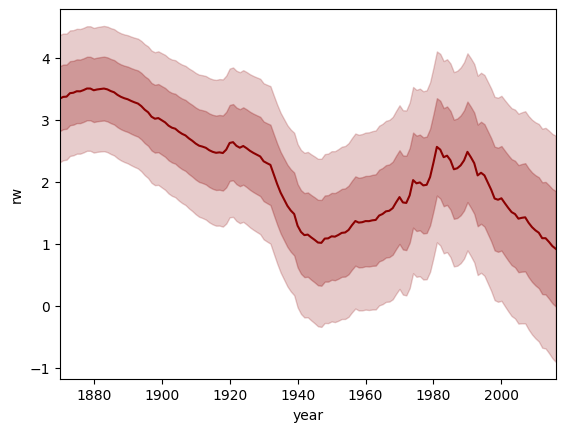

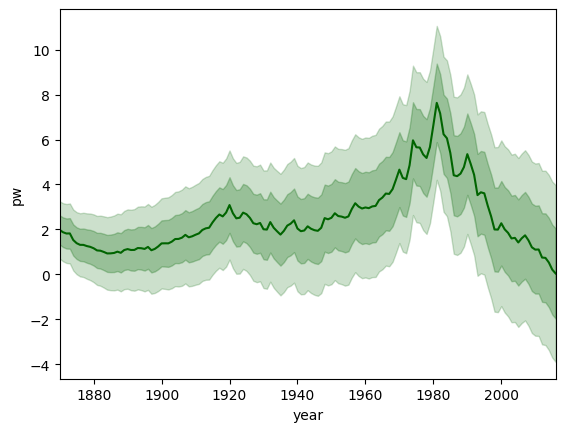

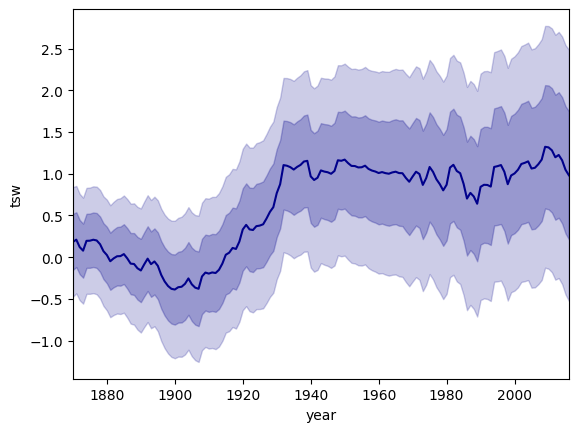

In [31]:
for var,color in {'rw':'darkred','pw':'darkgreen','tsw':'darkblue'}.items():
    ci95, ci68= conf_int(xi_df.columns.get_loc(var),xi_df,P_df)
    sns.lineplot(data=xi_df, x="year", y=var,color=color)
    plt.fill_between(year['year'],ci95[:,1], ci95[:,0], alpha=.2,color=color)
    plt.fill_between(year['year'],ci68[:,1], ci68[:,0], alpha=.25,color=color)
    plt.xlim([1870, 2016])
    # plt.ylim([-1, 8])
    plt.show()